## How does the approximation of WH ~ X perform as we increase the rank k?

In [1]:
from ristretto import nmf
import numpy
import matplotlib.pyplot as plt
import pandas

def nmf_approximation_error(matrix, k, method = 'nmf_fhals'):
    if method == 'nmf_fhals':
        W,H = nmf.nmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    elif method == 'rnmf_fhals':
        W,H = nmf.rnmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    else:
        return None


nmf_error_tracker = {}
rnmf_error_tracker = {}
X = numpy.random.rand(1000,1000)
for k in range(200, 500, 50):
    nmf_error = []
    for trial in xrange(3):
        nmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    nmf_error_tracker[k] = numpy.mean(nmf_error)

    rnmf_error = []
    for trial in xrange(3):
        rnmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    rnmf_error_tracker[k] = numpy.mean(rnmf_error)

/Users/hyunjoonsong/Documents/MIT/MEng_Year/18.065/venv/lib/python2.7/site-packages/matplotlib/pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


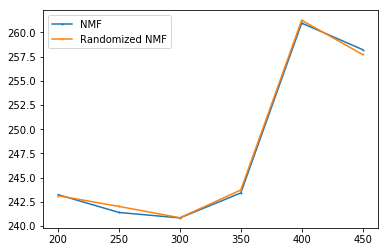

In [2]:
nmf_df = pandas.DataFrame([nmf_error_tracker.keys(), nmf_error_tracker.values()]).T.sort_values(0)
nmf_df.columns = ['x','y']
rnmf_df = pandas.DataFrame([rnmf_error_tracker.keys(), rnmf_error_tracker.values()]).T.sort_values(0)
rnmf_df.columns = ['x','y']
plt.plot('x', 'y', data = nmf_df, linestyle='-', marker='o', markersize = 1, label='NMF')
plt.plot('x', 'y', data = rnmf_df, linestyle='-', marker='d', markersize = 1, label='Randomized NMF')
plt.legend()
plt.show()
plt.close()

## NMF Code

In [1]:
import numpy
import nmf
import time
from oct2py import octave
octave.addpath("/Users/hyunjoonsong/Documents/MIT/MEng_Year/18.065/symnmf")

A = numpy.random.rand(100,100)
S = (A + A.T)/2

octave.push('A', A)
octave.push('S', S)

start = time.time()
W, H = nmf.nmf_fhals(A, 2)
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(W.dot(H) - A)

Time elapsed: 0.010187
27.957701294870468


In [25]:
start = time.time()
octave.eval('[W, H] = nmf_fhals(A, 2)', verbose=False)
W = octave.pull('W')
H = octave.pull('H')
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(W.dot(H) - A)

Time elapsed: 5.410603
27.809088715762154


In [26]:
start = time.time()
H = nmf.snmf_fhals(S, 2)
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(H.dot(H.T) - S)

Time elapsed: 10.564892
20.154697808397852


In [27]:
start = time.time()
H = octave.eval('symnmf_anls(S, 2)', verbose=False)
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(H.dot(H.T) - S)

Time elapsed: 0.119673
20.154673414111407


In [44]:
start = time.time()
octave.eval('[W, H] = jointnmf(A, S, 2)', verbose=False)
W = octave.pull('W')
H = octave.pull('H')
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(W.dot(H) - A)

Time elapsed: 2.042399
28.727775328100424


In [ ]:
from sklearn.decomposition import NMF

start = time.time()
model = NMF(n_components=2, init='random', random_state=0)
print("Time elapsed: %f" % (time.time() - start))
W = model.fit_transform(S)
H = model.components_
print numpy.linalg.norm(W.dot(H) - S)

In [2]:
import numpy
genomes = numpy.load('CEU_YRI_ASW_34866.npy').astype(numpy.float64)

In [9]:
W, H = nmf.nmf_fhals(genomes,2)
Ht_norm = H.T/H.T.sum(axis = 1)[:, numpy.newaxis]

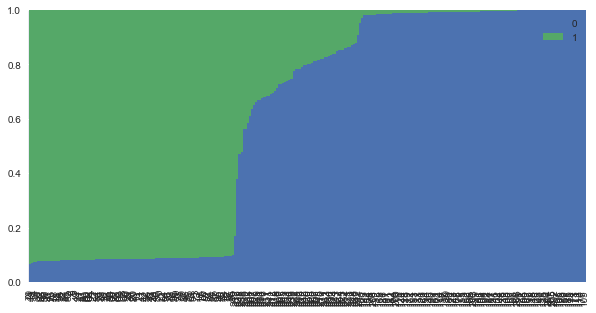

In [12]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
pandas.DataFrame(Ht_norm).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()

In [28]:
rW, rH = nmf.rnmf_fhals(genomes.T,2)
rW_norm = rW/rW.sum(axis = 1)[:, numpy.newaxis]

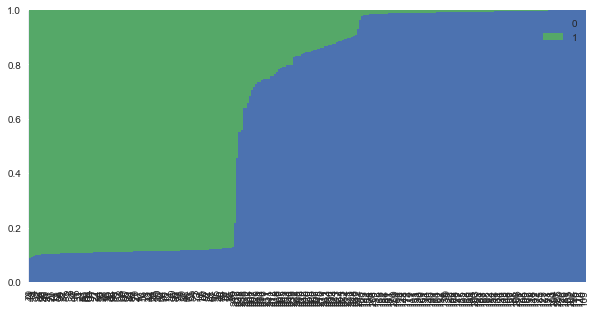

In [35]:
sns.set()
pandas.DataFrame(rW_norm).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()
plt.close()

In [13]:
from scipy import stats
import scipy

In [14]:
corr = numpy.zeros((len(genomes.T),len(genomes.T)))
for i in xrange(len(genomes.T)):
    for j in xrange(len(genomes.T)):
        corr[i,j] = stats.pearsonr(genomes.T[i],genomes.T[j])[0]

In [15]:
octave.push('C', corr)
H = octave.eval('symnmf_anls(C, 2)', verbose=False)

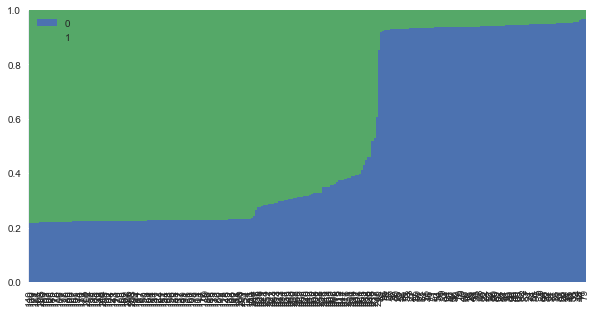

In [16]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
pandas.DataFrame(H/H.sum(axis = 1)[:, numpy.newaxis]).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()
plt.close()

In [17]:
octave.push('G', genomes)
octave.push('C', corr)
octave.eval('[W, H] = jointnmf(G, C, 2)', verbose=False)
W = octave.pull('W')
H = octave.pull('H')
Ht_norm = H.T/H.T.sum(axis = 1)[:, numpy.newaxis]

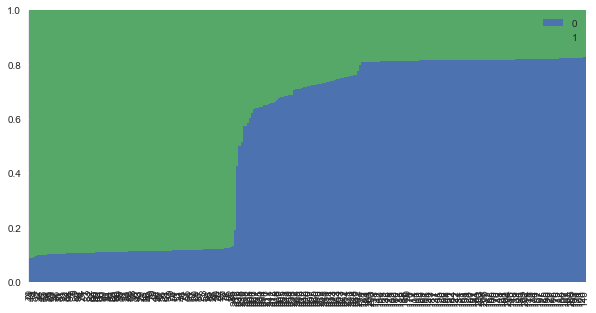

In [18]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
pandas.DataFrame(Ht_norm).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()